# Lista 03

Artificial neural networks for image classification.

## Common Functions

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
def create_image_panel(images, labels, cols=3, title=None):

    if len(images) != len(labels):
        raise ValueError("Number of images and labels must be equal.")

    rows = int(len(images) / cols) + (len(images) % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(5, rows * 2))

    for i in range(rows*cols):
        row, col = divmod(i, cols)
        if rows == 1:
            axs = axes[col]
        else:
            axs = axes[row, col]
        if i < len(images):
            axs.imshow(images[i])
            axs.set_title(labels[i])
        axs.axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    return fig

## Database

 https://medmnist.com/

In [5]:
from medmnist import BloodMNIST
train_dataset = BloodMNIST(split="train", download=True)
val_dataset = BloodMNIST(split="val", download=True)
test_dataset = BloodMNIST(split="test", download=True)

Using downloaded and verified file: C:\Users\tiago.LENOVO-I7\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\tiago.LENOVO-I7\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\tiago.LENOVO-I7\.medmnist\bloodmnist.npz


In [42]:
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\tiago.LENOVO-I7\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28

In [77]:
labels = [
    'basophil',
    'eosinophil',
    'erythroblast',
    'immature granulocytes',
    'lymphocyte',
    'monocyte',
    'neutrophil',
    'platelet'
]

In [32]:
X_train = train_dataset.imgs[:]
y_train = train_dataset.labels[:,0]

X_val = val_dataset.imgs[:]
y_val = val_dataset.labels[:,0]

X_test = test_dataset.imgs[:]
y_test = test_dataset.labels[:,0]

In [34]:
print(f"Train data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")

Train data: (11959, 28, 28, 3)
Validation data: (1712, 28, 28, 3)
Test data: (3421, 28, 28, 3)


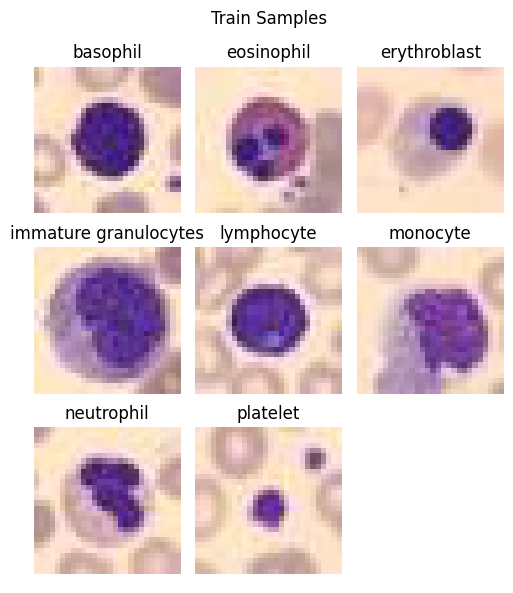

In [73]:
images = []
for i in range(len(labels)):
    images.append(X_train[y_train==i][0])

image_panel = create_image_panel(images, labels, title="Train Samples")
plt.show(image_panel)

## MLP

In [35]:
from tensorflow import keras

In [94]:
mlp = keras.models.Sequential(
    [
        keras.layers.Input(shape=(28,28,3)),
        keras.layers.Flatten(),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(len(labels), activation="softmax")
    ]
)

In [95]:
mlp.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │       705,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         2,408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 708,308 (2.70 MB)

 Trainable params: 708,308 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
mlp.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],
)

In [97]:
mlp_history = mlp.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data = (X_val, y_val)
)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - acc: 0.3603 - loss: 241.9708 - val_acc: 0.4685 - val_loss: 14.8479
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.5062 - loss: 11.7192 - val_acc: 0.3773 - val_loss: 8.5192
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.4004 - loss: 3.7792 - val_acc: 0.3213 - val_loss: 1.7622
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - acc: 0.3165 - loss: 1.7635 - val_acc: 0.3131 - val_loss: 1.7525
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.3227 - loss: 1.7276 - val_acc: 0.3277 - val_loss: 1.6924
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - acc: 0.3290 - loss: 1.6984 - val_acc: 0.3271 - val_loss: 1.6712
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - acc: 0.3242 - loss: 1.6967 - val_acc: 0.3283 - val_loss: 1.6458
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - acc: 0.3311 - loss: 1.6504 - val_acc: 0.3259 - val_loss: 1.6603
Epoch 9/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 1

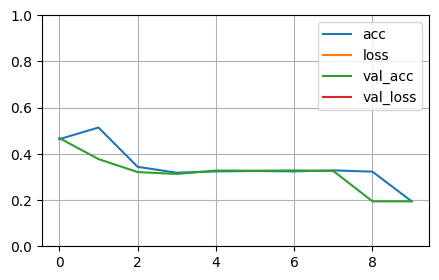

In [98]:
pd.DataFrame(mlp_history.history).plot(figsize=(5,3))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Simple CNN

## Deep CNN